In [1]:
#%%
import os
import FinanceDataReader as fdr
from bt.algos import RunDaily
from pypfopt.expected_returns import prices_from_returns
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import quantstats as qs
import seaborn as sns
import sys

pd.options.display.float_format = '{:.4f}'.format
plt.style.use('default') #ggplot
plt.rcParams['font.family'] = 'nanummyeongjo'
plt.rcParams['figure.figsize'] = [12,8]
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.grid'] = True

plt.rcParams['axes.formatter.useoffset'] = False
# plt.rcParmas['axes.formatter.limits'] = -1000, 1000

plt.rcParams['axes.unicode_minus'] = False

from IPython.display import display, HTML

# sys.path.insert(0, "/Users/hosung/workspace/git/bt/")
# for p in sys.path:
#     print(p)
%matplotlib inline

import bt
bt.__version__

(0, 2, 9)

In [2]:
def long_only_ew(data, tickers, start_date, name='long_only_ew', initial_capital=1000000.0):
    s = bt.Strategy(name,
    [
        bt.algos.RunAfterDate(start_date),
        bt.algos.RunOnce(),
        bt.algos.SelectThese(tickers),
        bt.algos.WeighEqually(),
        bt.algos.Rebalance()
    ])
    return bt.Backtest(s, data, initial_capital=initial_capital)

In [3]:
df = pd.read_csv('asset_db.csv', index_col=0, parse_dates=True)

In [4]:
cols = ['us500_Hx2', 'kbond20y', 'kodex200x2', 'usdkrwx2']
price_df = df[cols].copy()
for c in price_df:
    print(c, price_df[c].first_valid_index())

us500_Hx2 1981-05-01 00:00:00
kbond20y 1981-05-01 00:00:00
kodex200x2 1981-05-01 00:00:00
usdkrwx2 1981-05-01 00:00:00


In [5]:
price_df['1985-10'].tail(2)

/var/folders/68/pm9snk_d53j26rdq0n4v_jn80000gn/T/ipykernel_78378/572385914.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  price_df['1985-10'].tail(2)


,us500_Hx2,kbond20y,kodex200x2,usdkrwx2
Date,,,,
1985-10-30,388.4722,819.4888,527.9910,4753.0506
1985-10-31,387.4241,821.6153,520.8193,4750.2029


In [6]:
price_df['1986-10'].tail(2)

/var/folders/68/pm9snk_d53j26rdq0n4v_jn80000gn/T/ipykernel_78378/779653957.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  price_df['1986-10'].tail(2)


,us500_Hx2,kbond20y,kodex200x2,usdkrwx2
Date,,,,
1986-10-30,614.7555,981.1386,1454.1757,4662.7489
1986-10-31,616.0761,979.4770,1457.7345,4664.1452


In [7]:
price_df.tail(2)

,us500_Hx2,kbond20y,kodex200x2,usdkrwx2
Date,,,,
2021-09-30,32685.0000,126480.0000,24560.0000,10105.0000
2021-10-01,31075.0000,125820.0000,23610.0000,10170.0000


In [8]:
start_date = '1986-10-30'
price_df = price_df.dropna()['1985-10-30':]

In [9]:
def strategy_aibeta(price_df, lookback=3, max=0.5):
    st = bt.Strategy(f"AIBeta_{lookback}_{max:.2f}",
                    [
                        bt.algos.RunAfterDate(start_date),
                        bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=True),
                        # bt.algos.PrintDate(),
                        bt.algos.SelectAll(),
                        bt.algos.WeighMeanVar(lookback=pd.DateOffset(months=lookback), lag = pd.DateOffset(days=1),
                                            bounds=(0.0, max), covar_method='standard'),
                        bt.algos.Rebalance()
                    ])
    bt_ai_beta = bt.Backtest(st, price_df)
    return bt_ai_beta

In [10]:
test_aibeta = {}
for lookback in range(3, 13):
    # print(f"lookback : {lookback}")
    for bound in np.arange(0.35, 0.5, 0.05):
        test_aibeta[f'AIBeta_{lookback}_{bound:.2f}'] = strategy_aibeta(price_df, lookback, bound)
# %%
rm = bt.run(*test_aibeta.values())

/Users/hosung/miniconda3/envs/py38/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/hosung/miniconda3/envs/py38/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/hosung/miniconda3/envs/py38/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/hosung/miniconda3/envs/py38/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


In [11]:
stats = rm.prices[start_date:].calc_stats().stats
stats

,AIBeta_3_0.35,AIBeta_3_0.40,AIBeta_3_0.45,AIBeta_3_0.50,AIBeta_4_0.35,AIBeta_4_0.40,AIBeta_4_0.45,AIBeta_4_0.50,AIBeta_5_0.35,AIBeta_5_0.40,...,AIBeta_10_0.45,AIBeta_10_0.50,AIBeta_11_0.35,AIBeta_11_0.40,AIBeta_11_0.45,AIBeta_11_0.50,AIBeta_12_0.35,AIBeta_12_0.40,AIBeta_12_0.45,AIBeta_12_0.50
start,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,...,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00,1986-10-30 00:00:00
end,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,...,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00,2021-10-01 00:00:00
rf,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
total_return,156.1153,177.0707,240.1073,265.6152,195.2417,177.1559,178.1020,183.5261,198.6186,211.6898,...,192.4824,183.0193,221.6259,220.4598,228.8943,230.2821,204.5804,180.3506,171.8484,160.5271
cagr,0.1558,0.1600,0.1701,0.1735,0.1632,0.1600,0.1602,0.1612,0.1638,0.1659,...,0.1627,0.1611,0.1674,0.1672,0.1685,0.1687,0.1648,0.1606,0.1590,0.1567
max_drawdown,-0.2938,-0.2891,-0.3077,-0.3241,-0.3363,-0.3053,-0.3078,-0.3240,-0.3344,-0.3549,...,-0.3108,-0.3383,-0.2687,-0.2898,-0.3078,-0.3246,-0.2686,-0.2891,-0.3079,-0.3247
calmar,0.5303,0.5534,0.5528,0.5352,0.4853,0.5241,0.5203,0.4975,0.4898,0.4675,...,0.5236,0.4761,0.6231,0.5771,0.5473,0.5197,0.6135,0.5554,0.5164,0.4828
mtd,-0.0152,-0.0141,-0.0132,-0.0124,-0.0143,-0.0132,-0.0126,-0.0121,-0.0143,-0.0127,...,-0.0167,-0.0159,-0.0210,-0.0216,-0.0197,-0.0185,-0.0243,-0.0249,-0.0223,-0.0196
three_month,-0.0082,-0.0113,-0.0109,-0.0102,0.0124,0.0201,0.0196,0.0192,0.0125,0.0164,...,-0.0194,-0.0192,-0.0371,-0.0364,-0.0319,-0.0257,-0.0325,-0.0285,-0.0210,-0.0125
six_month,0.0447,0.0350,0.0328,0.0304,0.0641,0.0668,0.0641,0.0630,0.0829,0.0835,...,0.0440,0.0455,0.0307,0.0245,0.0296,0.0377,0.0265,0.0323,0.0350,0.0433


In [12]:
stats.to_csv('AIBeta_results_extend_spyleverage.csv')

In [13]:
stats = stats.loc[['total_return', 'cagr', 'max_drawdown', 'daily_sharpe'],:].T
stats.columns = ['return', 'cagr', 'mdd', 'sharpe']
stats['mdd'] = stats['mdd']*-1
stats.sort_values(by='return', ascending=False)

,return,cagr,mdd,sharpe
AIBeta_3_0.50,265.6152,0.1735,0.3241,0.9953
AIBeta_6_0.50,251.7018,0.1717,0.3353,0.9700
AIBeta_7_0.50,247.4688,0.1711,0.3242,0.9641
AIBeta_6_0.40,244.7107,0.1707,0.3287,1.0276
AIBeta_10_0.35,243.2425,0.1705,0.2688,1.0627
AIBeta_3_0.45,240.1073,0.1701,0.3077,1.0235
AIBeta_9_0.35,238.0876,0.1698,0.2685,1.0645
AIBeta_6_0.45,237.6456,0.1697,0.3450,0.9953
AIBeta_11_0.50,230.2821,0.1687,0.3246,0.9644
AIBeta_11_0.45,228.8943,0.1685,0.3078,1.0066


<AxesSubplot:>

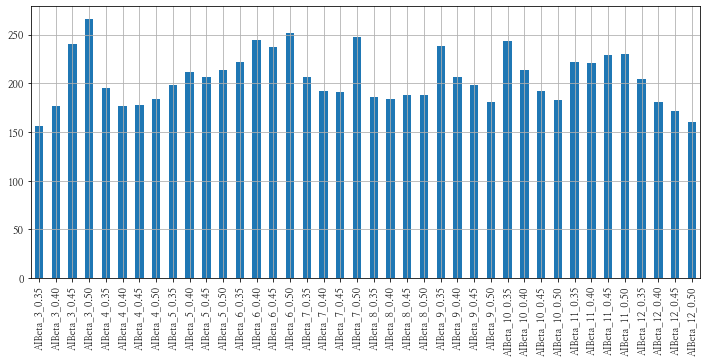

In [14]:
stats['return'].plot.bar(figsize=(12, 5))#, secondary_y=['mdd'])

<AxesSubplot:>

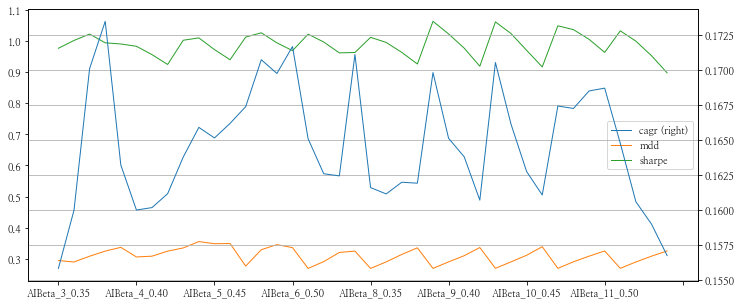

In [15]:
stats[['cagr', 'mdd', 'sharpe']].plot(figsize=(12,5), secondary_y=['cagr'])

In [16]:
bt_ew = long_only_ew(price_df, cols, start_date, "ew")

bt_kodex200x2 = long_only_ew(price_df, ["kodex200x2"], start_date, "kodex200x2")
bt_kbond20y = long_only_ew(price_df, ["kbond20y"], start_date, "kbond20y")
bt_us500_Hx2 = long_only_ew(price_df, ["us500_Hx2"], start_date, "us500_Hx2")
bt_usdkrwx2 = long_only_ew(price_df, ["usdkrwx2"], start_date, "usdkrwx2")

bt_ai_beta_35 = strategy_aibeta(price_df, 3, 0.35)
bt_ai_beta_50 = strategy_aibeta(price_df, 3, 0.50)

In [17]:
r = bt.run(bt_ai_beta_35, bt_ai_beta_50, bt_kodex200x2, bt_kbond20y, bt_us500_Hx2, bt_usdkrwx2)

In [18]:
r.set_date_range(start=start_date)
r.display()

Stat                 AIBeta_3_0.35    AIBeta_3_0.50    kodex200x2    kbond20y    us500_Hx2    usdkrwx2
-------------------  ---------------  ---------------  ------------  ----------  -----------  ----------
Start                1986-10-30       1986-10-30       1986-10-30    1986-10-30  1986-10-30   1986-10-30
End                  2021-10-01       2021-10-01       2021-10-01    2021-10-01  2021-10-01   2021-10-01
Risk-free rate       0.00%            0.00%            0.00%         0.00%       0.00%        0.00%

Total Return         15611.53%        26575.36%        1517.43%      12733.73%   4943.48%     117.83%
Daily Sharpe         0.98             1.00             0.40          1.24        0.48         0.21
Daily Sortino        1.56             1.58             0.66          1.87        0.74         0.33
CAGR                 15.58%           17.35%           8.30%         14.91%      11.88%       2.25%
Max Drawdown         -29.38%          -32.41%          -96.06%       -41.47%     

/Users/hosung/miniconda3/envs/py38/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1389: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, None)


<AxesSubplot:>

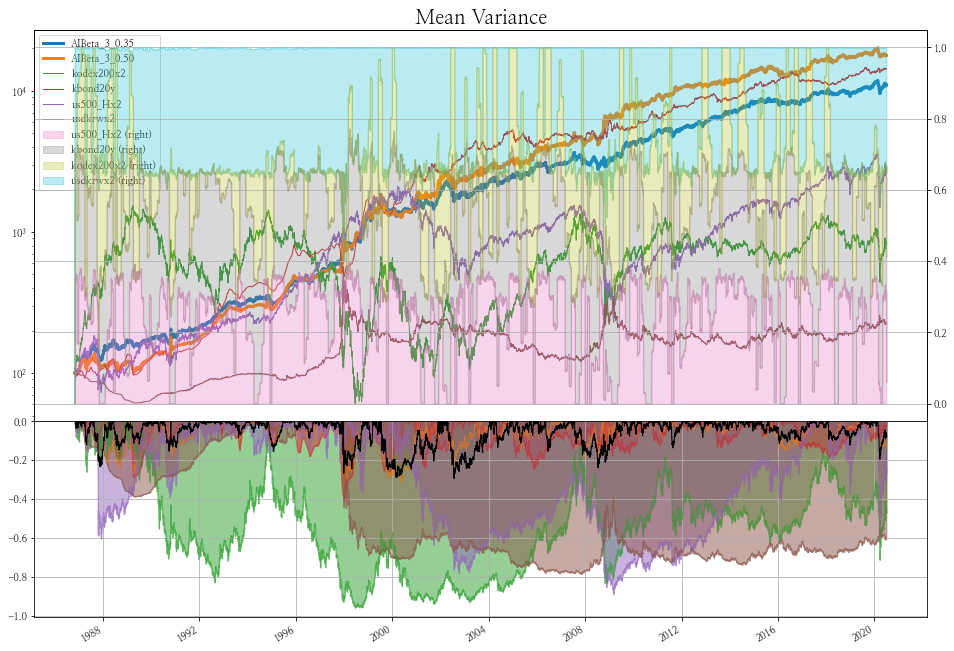

In [19]:
res1 = r
start = start_date
end = '2020-06-30'
plt.rcParams["figure.figsize"] = [16, 12]
plt.subplots_adjust(hspace=0)

# 첫번째 칸에 그림을 그린다.
ax1 = plt.subplot2grid((3,1), (0,0), rowspan=2)
# 두개를 한 칸에 그리기 위해 ax=ax1으로 axis공유
ax2 = res1.prices[start:end].plot(ax=ax1, style=['-', '-', '-', '-', '-', '-', '-'], lw=1, logy=True) # 모든 데이터 r_all
for line in ax2.get_lines():
    if line.get_label() == 'AIBeta_3_0.35' or line.get_label() == 'AIBeta_3_0.50' or line.get_label() == 'AIBet_InvVol':
        line.set_linewidth(3)
plt.legend(loc="upper left");
plt.title('Mean Variance', fontsize=20)
res1.get_security_weights('AIBeta_3_0.35')[start:end].plot.area(alpha=0.3, ax=ax1, secondary_y=True)


# 두번째 칸에 그림을 그린다.
# drawdown을 그림다. 두개를 하나에 그리기 위해 ax=ax2로 axis를 공유
ax2 = plt.subplot2grid((3,1), (2,0))
res1.prices[start:end].to_drawdown_series().plot.area(stacked=False,legend=False, ax=ax2)
res1.prices.loc[start:end,'AIBeta_3_0.35'].to_drawdown_series().plot(legend=False, color='black', alpha=1, lw=1, ls='-', ax=ax2)


In [20]:
r.display_monthly_returns('AIBeta_3_0.35')

  Year    Jan    Feb    Mar    Apr    May    Jun    Jul    Aug    Sep     Oct    Nov    Dec    YTD
------  -----  -----  -----  -----  -----  -----  -----  -----  -----  ------  -----  -----  -----
  1986   0      0      0      0      0      0      0      0      0      -0     -0.17   2      1.82
  1987  15.09   6.55  11.52  -9.43   5.83   8.76   2.57   0.54  -3.23  -10.28  -3.21   7.4   32.68
  1988  14.22  -5.36   7.89   0.47   7.35  -4.63  -1.58  -8.18   3.57    2.15   1.77   6.69  24.51
  1989  -0.2   -0.08  -4.82  -1.29   1.88  -5.44   7.42   3.99   0.27   -0.62   1.92   1.45   3.89
  1990   1.06   1.81   0.58  -4.69   6.41   0.96   0.52  -8.24  -4.99   11.47   1.09   1      5.69
  1991   0.18   5.23   1.11   0.9    1.09  -1.93   2.9   -1.48   1.29    2.17  -1.39   2.65  13.22
  1992   3.5    1.84   0.01   2.88   1.3    1.6    7.51  -0.04   4.08    5.79   0.43   3.38  37.12
  1993   2.78   4.09   3.89  -1.27   0.76  -1.3   -1.84  -2.74   2.34    1.86   1.01   3.21  13.24
  1994   3

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               1986-10-31  1986-10-31
End Period                 2021-10-01  2021-10-01
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          15,611.53%  26,575.36%
CAGR﹪                     15.57%      17.34%

Sharpe                     0.98        1.0
Smart Sharpe               0.9         0.92
Sortino                    1.42        1.48
Smart Sortino              1.31        1.36
Sortino/√2                 1.0         1.04
Smart Sortino/√2           0.92        0.96
Omega                      1.21        1.21

Max Drawdown               -29.38%     -32.41%
Longest DD Days            868         919
Volatility (ann.)          15.42%      16.84%
R^2                        0.75        0.75
Calmar                     0.53        0.53
Skew                       -0.59       -0.26
Kurtosis                   37.52    

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2002-04-19,2002-07-26,2004-01-16,637,-29.3821,-26.8211
2,1999-07-12,2000-02-28,2001-11-26,868,-28.8518,-27.9625
3,1997-12-24,1997-12-26,1998-10-12,292,-26.8629,-24.1274
4,2007-07-24,2008-07-15,2009-07-20,727,-23.9402,-22.5470
5,1987-08-22,1987-11-16,1988-04-06,228,-23.2414,-23.0468


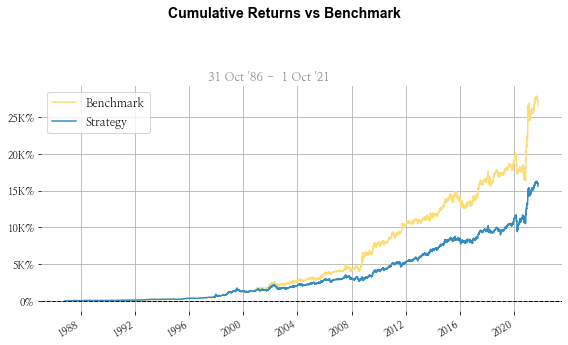

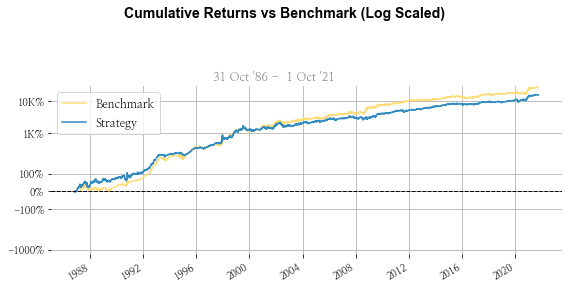

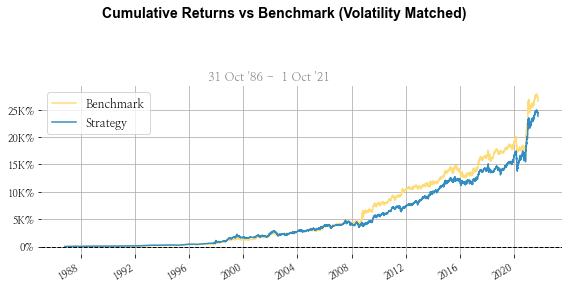

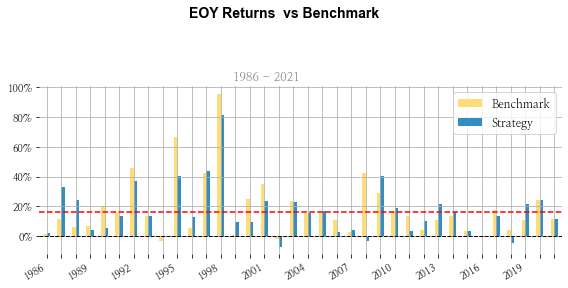

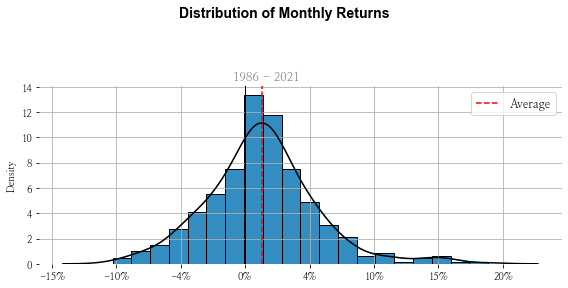

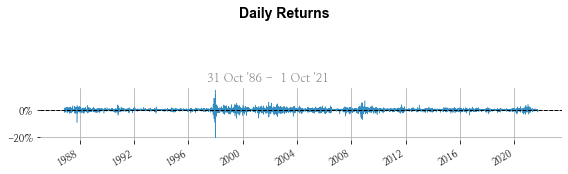

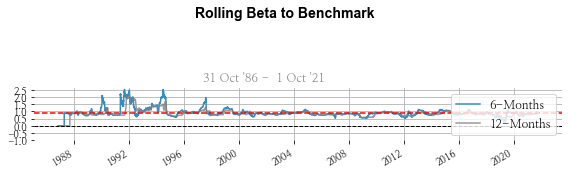

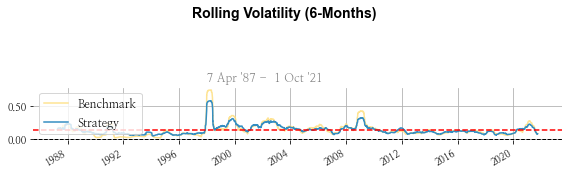

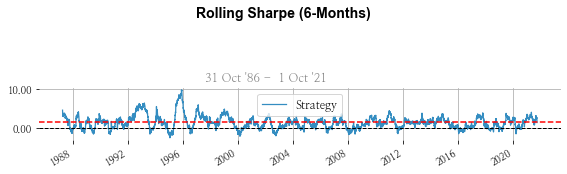

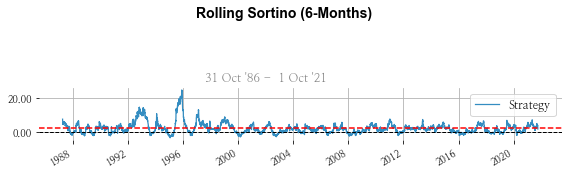

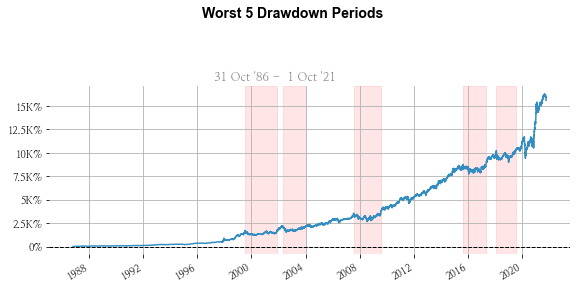

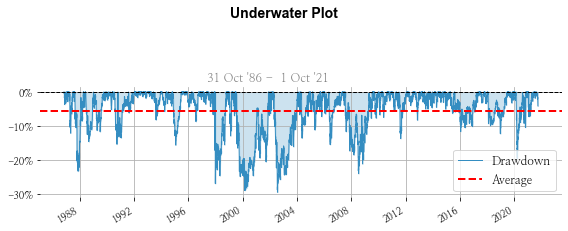

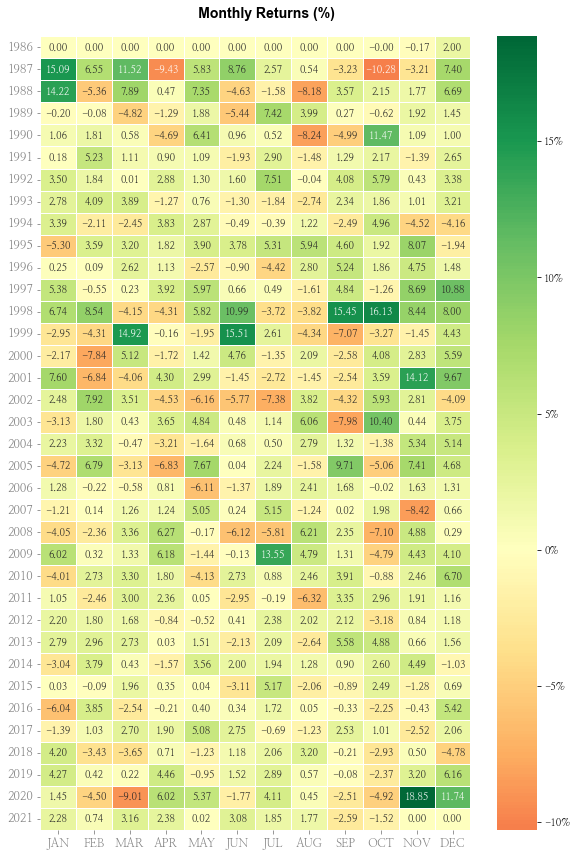

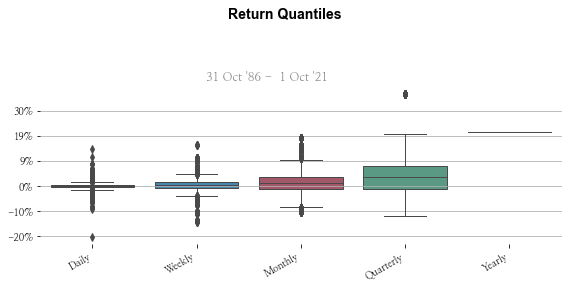

In [21]:
qs.reports.full(r.prices['AIBeta_3_0.35'].to_returns().dropna(), r.prices['AIBeta_3_0.50'].to_returns().dropna())

In [22]:
r.prices.calc_cagr()

AIBeta_3_0.35   0.1558
AIBeta_3_0.50   0.1735
kodex200x2      0.0830
kbond20y        0.1491
us500_Hx2       0.1188
usdkrwx2        0.0225
dtype: float64

2021-10-01 00:00:00


<AxesSubplot:>

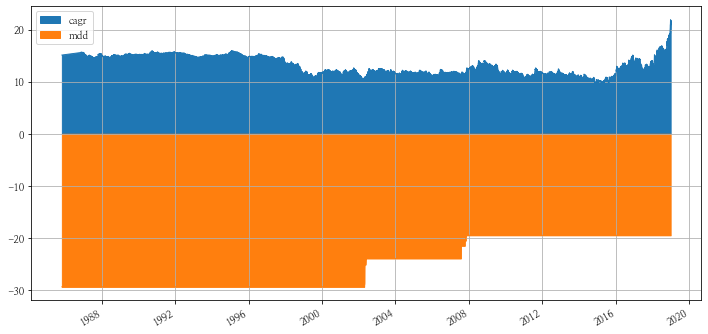

In [23]:
r_ai = bt.run(bt_ai_beta_35)
cagrs = {}
mdds = {}
# for m in pd.date_range(start_date, '2021-10', freq='M'):
for m in r_ai.prices.index:
    # print(m)
    try:
        cagrs[m] = r_ai.prices[m:].calc_cagr().values[0]
        mdds[m] = r_ai.prices[m:].calc_max_drawdown().values[0]
    except:
        print(m)

cagr_df = pd.DataFrame([cagrs]).T*100
mdd_df = pd.DataFrame([mdds]).T*100

tdf = bt.merge(cagr_df, mdd_df)
tdf.columns = ['cagr', 'mdd']

tdf[:'2018'].plot.area(figsize=(12,6))

In [24]:
tdf.to_csv("AIBeta_3개월_0.35_CAGR_MDD_spyleverage.csv")

2021-10-01 00:00:00


<AxesSubplot:>

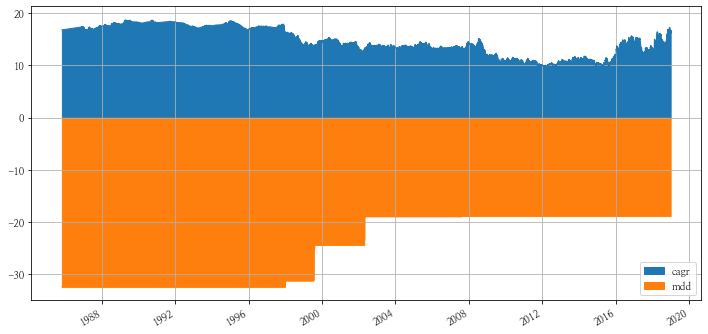

In [25]:
r_ai = bt.run(bt_ai_beta_50)
cagrs = {}
mdds = {}
# for m in pd.date_range(start_date, '2021-10', freq='M'):
for m in r_ai.prices.index:
    # print(m)
    try:
        cagrs[m] = r_ai.prices[m:].calc_cagr().values[0]
        mdds[m] = r_ai.prices[m:].calc_max_drawdown().values[0]
    except:
        print(m)

cagr_df = pd.DataFrame([cagrs]).T*100
mdd_df = pd.DataFrame([mdds]).T*100

tdf = bt.merge(cagr_df, mdd_df)
tdf.columns = ['cagr', 'mdd']

tdf[:'2018'].plot.area(figsize=(12,6))

In [26]:
tdf.to_csv("AIBeta_3개월_0.50_CAGR_MDD_spyleverage.csv")